<a href="https://colab.research.google.com/github/Chikuji/AzureML/blob/master/2020_09_23_02_ImplantarPipelinesEmLote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos de aprendizado

Neste módulo, você aprenderá como:

- Publique o pipeline de inferência em lote para um modelo treinado.
-Use um pipeline de inferência em lote para gerar previsões.


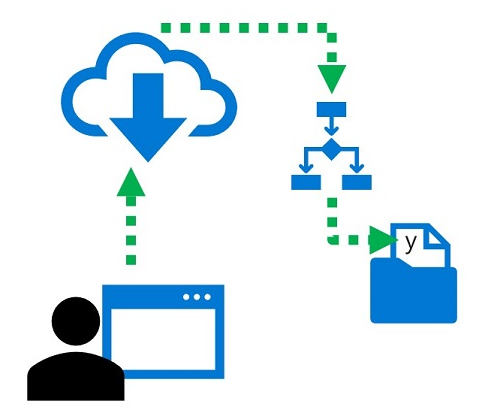

# Criação de um pipeline de inferência em lote

# 1. Registre um modelo

In [ ]:
from azureml.core import Model

classification_model = Model.register(workspace=your_workspace,
                                      model_name='classification_model',
                                      model_path='model.pkl', # local path
                                      description='A classification model')

Como alternativa, se você tiver uma referência ao Run usado para treinar o modelo, poderá usar seu método register_model

In [ ]:
run.register_model( model_name='classification_model',
                    model_path='outputs/model.pkl', # run outputs path
                    description='A classification model')

# 2. Crie um script de pontuação

O serviço de inferência em lote requer um script de pontuação para carregar o modelo e usá-lo para prever novos valores. Deve incluir duas funções:

- init () : Chamado quando o pipeline é inicializado.
-run (mini_batch) : Chamado para cada lote de dados a ser processado.

In [ ]:
import os
import numpy as np
from azureml.core import Model
import joblib

def init():
    # Runs when the pipeline step is initialized
    global model

    # load the model
    model_path = Model.get_model_path('classification_model')
    model = joblib.load(model_path)

def run(mini_batch):
    # This runs for each batch
    resultList = []

    # process each file in the batch
    for f in mini_batch:
        # Read comma-delimited data into an array
        data = np.genfromtxt(f, delimiter=',')
        # Reshape into a 2-dimensional array for model input
        prediction = model.predict(data.reshape(1, -1))
        # Append prediction to results
        resultList.append("{}: {}".format(os.path.basename(f), prediction[0]))
    return resultList

# 3. Crie um pipeline com um ParallelRunStep

In [ ]:
from azureml.pipeline.steps import ParallelRunConfig, ParallelRunStep
from azureml.pipeline.core import PipelineData
from azureml.pipeline.core import Pipeline

# Get the batch dataset for input
batch_data_set = ws.datasets('batch-data')

# Set the output location
default_ds = ws.get_default_datastore()
output_dir = PipelineData(name='inferences',
                          datastore=default_ds,
                          output_path_on_compute='results')

# Define the parallel run step step configuration
parallel_run_config = ParallelRunConfig(
    source_directory='batch_scripts',
    entry_script="batch_scoring_script.py",
    mini_batch_size="5",
    error_threshold=10,
    output_action="append_row",
    environment=batch_env,
    compute_target=aml_cluster,
    node_count=4)

# Create the parallel run step
parallelrun_step = ParallelRunStep(
    name='batch-score',
    parallel_run_config=parallel_run_config,
    inputs=[batch_data_set.as_named_input('batch_data')],
    output=output_dir,
    arguments=[],
    allow_reuse=True
)
# Create the pipeline
pipeline = Pipeline(workspace=ws, steps=[parallelrun_step])

# 4. Execute o pipeline e recupere a saída da etapa

In [ ]:
from azureml.core import Experiment

# Run the pipeline as an experiment
pipeline_run = Experiment(ws, 'batch_prediction_pipeline').submit(pipeline)
pipeline_run.wait_for_completion(show_output=True)

# Get the outputs from the first (and only) step
prediction_run = next(pipeline_run.get_children())
prediction_output = prediction_run.get_output_data('inferences')
prediction_output.download(local_path='results')

# Find the parallel_run_step.txt file
for root, dirs, files in os.walk('results'):
    for file in files:
        if file.endswith('parallel_run_step.txt'):
            result_file = os.path.join(root,file)

# Load and display the results
df = pd.read_csv(result_file, delimiter=":", header=None)
df.columns = ["File", "Prediction"]
print(df)

# Publicar um pipeline de inferência em lote

Você pode publicar um pipeline de inferência em lote como um serviço REST, conforme mostrado no seguinte código de exemplo:

In [ ]:
published_pipeline = pipeline_run.publish_pipeline(name='Batch_Prediction_Pipeline',
                                                   description='Batch pipeline',
                                                   version='1.0')
rest_endpoint = published_pipeline.endpoint

Depois de publicado, você pode usar o ponto de extremidade de serviço para iniciar um trabalho de inferência em lote, conforme mostrado no seguinte código de exemplo:

In [ ]:
import requests

response = requests.post(rest_endpoint,
                         headers=auth_header,
                         json={"ExperimentName": "Batch_Prediction"})
run_id = response.json()["Id"]

Você também pode agendar o pipeline publicado para que seja executado automaticamente, conforme mostrado no seguinte código de exemplo:

In [ ]:
from azureml.pipeline.core import ScheduleRecurrence, Schedule

weekly = ScheduleRecurrence(frequency='Week', interval=1)
pipeline_schedule = Schedule.create(ws, name='Weekly Predictions',
                                        description='batch inferencing',
                                        pipeline_id=published_pipeline.id,
                                        experiment_name='Batch_Prediction',
                                        recurrence=weekly)